# The following notebook includes:
* Was used dataset from raw audio files in wav format from the corpus with TED TALKS (claps, noise, somewhere pieces of music, so not only clean speech itself) 
* Feature extraction made using R-package
* Tried MLP network from the article
* Tried other ML algorithms with tuning parameters


In [1]:
import os, sys, inspect, multiprocessing

import pandas as pd
import numpy as np
from functools import reduce
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

##### Preprocessing with warbleR, which calculates all the parameters we need

In [2]:
try: 
    specan_data = pd.read_csv('../TED_specan.csv')
except FileNotFoundError:
    currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
    parentdir = os.path.dirname(currentdir)
    sys.path.insert(0,parentdir) 
    from process_input import make_csv_from_specan
    make_csv_from_specan(speakers_file='../ted_speakers.csv', audios_directory='../TED_audio', to_csv_file='../TED_specan.csv')
    specan_data = pd.read_csv('../TED_specan.csv')

##### In this dataset we have inbalanced situation, so we bootstrap women and add them in order to equate both sexes

In [3]:
print('Men: {} examples\nWomen: {} examples'.format(*specan_data.sex.value_counts()))

state = np.random.get_state()
np.random.seed(42)
indices = np.random.choice(specan_data[specan_data.sex == 0].index, 270)
np.random.set_state(state)
from sklearn.utils import shuffle
balanced_data = shuffle(pd.concat([specan_data, specan_data.iloc[indices]]), random_state=42)
print('\nAfter random sampling and adding women to dataframe\n')
print('Men: {} examples\nWomen: {} examples'.format(*balanced_data.sex.value_counts()))

Men: 524 examples
Women: 250 examples

After random sampling and adding women to dataframe

Men: 524 examples
Women: 520 examples


In [4]:
balanced_data = balanced_data.drop(['Unnamed: 0'], axis=1)

X_no_norm = balanced_data.drop(['sex'], axis=1)
y = balanced_data.sex

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X_no_norm)

##### MLP from the article


In [5]:
state = np.random.get_state()
np.random.seed(42)

from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Nadam
from keras.utils.np_utils import to_categorical

y = to_categorical(y, 2)

def neural_network():
    
    x_input = Input(shape=(21,))

    hidden1 = Dense(units=64, activation='tanh')(x_input)
    hidden1 = Dropout(0.25)(hidden1)
    hidden2 = Dense(units=256, activation='tanh')(hidden1)
    hidden2 = Dropout(0.25)(hidden2)
    hidden3 = Dense(units=256, activation='tanh')(hidden2)
    hidden3 = Dropout(0.25)(hidden3)
    hidden4 = Dense(units=64, activation='tanh')(hidden3)

    y_output = Dense(units=2, activation='softmax')(hidden4)

    model = Model(inputs=x_input, outputs=y_output)
    model.compile(loss='kullback_leibler_divergence', optimizer=Nadam(lr=1e-3), metrics=['accuracy'])
    
    return model

/Users/alexparub/Packages/miniconda3/envs/jupyter3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
from sklearn.model_selection import StratifiedKFold

kFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
epochs = 150
batch_size = 32

scores = []
for train, test in kFold.split(X, y[:, 0]):
    model = neural_network()
    model.fit(X[train], y[train], 
              validation_data=(X[test], y[test]), 
              epochs=epochs, batch_size=batch_size, verbose=0)
    score = model.evaluate(X[test], y[test], verbose=0)
    print('Accuracy: {:.3f}'.format(score[1]))
    scores.append(score[1])
print('Neural network: {:.3f}±{:.3f}'.format(np.mean(scores), np.std(scores)))
np.random.set_state(state)

Accuracy: 0.833
Accuracy: 0.813
Accuracy: 0.828
Accuracy: 0.813
Accuracy: 0.798
Neural network: 0.817±0.012


##### Other ML methods on cross-validation

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.learning_curve import validation_curve

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

/Users/alexparub/Packages/miniconda3/envs/jupyter3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/alexparub/Packages/miniconda3/envs/jupyter3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [8]:
X = pd.DataFrame(X, columns = X_no_norm.columns)
y = balanced_data.sex 

In [9]:
def cross_val_model(model, X, y, verbose=2):
    cv = StratifiedKFold(n_splits=5)
    scores = cross_val_score(model, X, y, cv=cv, verbose=verbose, scoring='accuracy')
    print('{}: {:.3f}±{:.3f}'.format(model.__class__.__name__, np.mean(scores), np.std(scores)))

In [10]:
boost = GradientBoostingClassifier(random_state = 42)
cross_val_model(boost, X, y, 0)

GradientBoostingClassifier: 0.826±0.019


In [11]:
forest = RandomForestClassifier(random_state = 42)
cross_val_model(forest, X, y, 0)

RandomForestClassifier: 0.811±0.021


In [12]:
svm = SVC(random_state = 42, probability=True)
cross_val_model(svm, X, y, 0)

SVC: 0.744±0.016


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
#stacked model
forest.fit(X_train, y_train)
svm.fit(X_train, y_train)
boost.fit(X_train, y_train)
combo = pd.DataFrame({'forest': forest.predict_proba(X_test)[:, 1], 
                      'svm': svm.predict_proba(X_test)[:, 1], 
                      'boost': boost.predict_proba(X_test)[:, 1]})
cross_val_model(boost, combo, y_test, 0)

GradientBoostingClassifier: 0.817±0.050


##### Feature importane

Index(['maxfun', 'mindom', 'dfrange', 'minfun', 'maxdom', 'freq.Q75',
       'meanfreq', 'sd', 'sfm', 'time.ent', 'entropy', 'freq.IQR', 'sp.ent',
       'meanpeakf', 'modindx', 'kurt', 'skew', 'meandom', 'freq.median',
       'freq.Q25', 'meanfun'],
      dtype='object')


<BarContainer object of 21 artists>

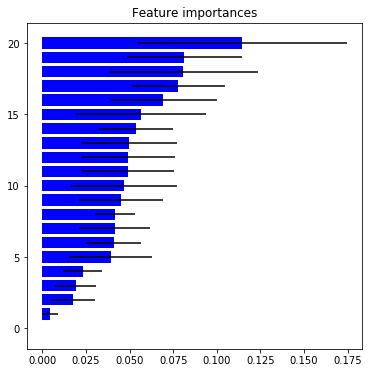

In [15]:
forest.fit(X_train, y_train)
fig, ax = plt.subplots(1, figsize=(6, 6))

indices = np.argsort(forest.feature_importances_)
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
print(X.columns[indices])
ax.set_title("Feature importances")
ax.barh(range(X.shape[1]), forest.feature_importances_[indices],
       color="b", xerr=std[indices], align="center")

##### Mean fundamental frequency

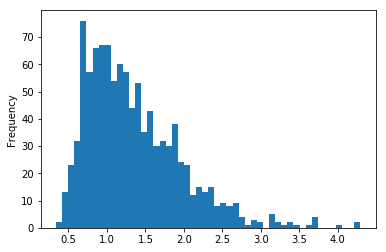

In [16]:
fig, ax = plt.subplots(1)

ax = balanced_data.meanfun.plot.hist(bins=50)

fig.savefig('histspec_50.png')

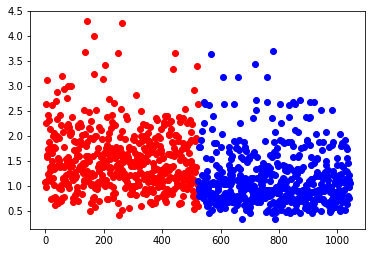

In [17]:
fig, ax = plt.subplots(1)

ax.plot(np.arange(np.sum(balanced_data.sex == 1)), balanced_data.meanfun[balanced_data.sex == 1], 'ro')
ax.plot(np.arange(np.sum(balanced_data.sex == 1), np.size(balanced_data.sex)), balanced_data.meanfun[balanced_data.sex == 0], 'bo')

##### Best scores on cross-validations gives Boosting and Stacked, let us tune their parameters

In [18]:
boost = GradientBoostingClassifier(random_state = 42)
parameters_b_new = {'learning_rate': np.arange(0.05,0.3, 0.05), 'n_estimators': np.arange(80, 160, 20)}
boosting_new = GridSearchCV(boost, param_grid = parameters_b_new, scoring='accuracy', verbose = 0, cv = 5)
boosting_new.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25]), 'n_estimators': array([ 80, 100, 120, 140])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_predict_boost = boosting_new.predict(X_test)
print(accuracy_score(y_predict_boost, y_test))
conf_mat = pd.DataFrame(confusion_matrix(y_predict_boost, y_test))
conf_mat

0.8318840579710145


,0,1
0,148,34
1,24,139


##### Random forest

In [20]:
forest = RandomForestClassifier(random_state = 42)
parameters_f_new = {'n_estimators': np.arange(20, 60, 5), 'max_depth': np.arange(2, 6, 1), 
                   'min_samples_leaf': np.arange(2, 6, 1)}
forest_new = GridSearchCV(forest, param_grid = parameters_f_new, scoring='accuracy', verbose = 0, cv = 5)
forest_new.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([20, 25, 30, 35, 40, 45, 50, 55]), 'max_depth': array([2, 3, 4, 5]), 'min_samples_leaf': array([2, 3, 4, 5])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [21]:
y_predict_fr = forest_new.predict(X_test)
print(accuracy_score(y_predict_fr, y_test))
conf_mat = pd.DataFrame(confusion_matrix(y_predict_fr, y_test))
conf_mat

0.744927536231884


,0,1
0,127,43
1,45,130


##### SVM


In [22]:
parameters_s_new = {'C': np.arange(0.1,1.2, 0.1), 'gamma': np.arange(0.1,1, 0.1)}
svm_new = GridSearchCV(svm, param_grid = parameters_s_new, scoring='accuracy', verbose = 0, cv = 3)
svm_new.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]), 'gamma': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [23]:
y_predict_svm = svm_new.predict(X_test)
print(accuracy_score(y_predict_svm, y_test))
conf_mat = pd.DataFrame(confusion_matrix(y_predict_svm, y_test))
conf_mat

0.8144927536231884


,0,1
0,120,12
1,52,161


In [24]:
#stacked model
boost.fit(X_train, y_train)
combo = pd.DataFrame({'forest': forest_new.predict_proba(X_test)[:, 1], 
                      'svm': svm_new.predict_proba(X_test)[:, 1], 
                      'boost': boosting_new.predict_proba(X_test)[:, 1]})
cross_val_model(boost, combo, y_test, 0)

def cross_val_model_new(model, X, y, verbose=2):
    cv = KFold(n_splits=5)
    scores = cross_val_score(model, X, y, cv=cv, verbose=verbose, scoring='accuracy')
    return (np.mean(scores))

GradientBoostingClassifier: 0.841±0.039


In [25]:
print('Choosen metric is accuracy')
print('Neural network from the article: {:.3f}'.format(np.mean(scores), np.std(scores)))
print('SVM: {:.3f}'.format(accuracy_score(y_predict_svm, y_test)))
print('Random forest: {:.3f}'.format(accuracy_score(y_test, y_predict_fr)))
print('Xgboost: {:.3f}'.format(accuracy_score(y_test, y_predict_boost)))
print('Stacked model: {:.3f}'.format(cross_val_model_new(boost, combo, y_test, 0)))

Choosen metric is accuracy
Neural network from the article: 0.817
SVM: 0.814
Random forest: 0.745
Xgboost: 0.832
Stacked model: 0.846


##### Accuracy decreased as noise appears in the data. Best model and score os Stacked model with 84.6%